### Pytorch 2 layer MLP Implementation

Pytorch is a package that allows easier implementation of deep learning architectures.  Its main benefits are easy implementation of matrix computation operations and automatic differentiation.  Parameters and operations are tracked and the package computes the gradients automatically.  You can define MLPs as a `nn.Module` class. After layers are defined, you choose how they operate on the input using the `forward` function.

You can define a fully connected layer as `nn.Linear(inputs, outputs)`, with inputs and outputs being the respective shapes.

In [26]:
#Pytorch Implementation of a 2 Layer MLP
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

#We first define an nn.Module, 
class MLP(nn.Module):
  def __init__(self, inputs=2, outputs=3, hiddens=32):
    super(MLP, self).__init__()
    #Define the layers in your MLP
    self.fc1 = nn.Linear(inputs, hiddens)
    self.fc2 = nn.Linear(hiddens, outputs)

  def forward(self, x):
    #Define operations on input x using the layers that were defined
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x), dim =1)
    return x
    

Torch objects operate on `torch.Tensor` objects.  You must take all NumPy datasets and convert them to the correct type of Tensor object.

Once the optimizer and loss function is defined, it is easy to use them to update the parameters in the network.  An example training loop is below.

In [27]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
from sklearn import datasets

warnings.filterwarnings('ignore')
dataset = datasets.load_iris()

x, y = dataset['data'], dataset['target']

#The dataset must be converted to a tensor of the correct type
x_tensor = Variable(torch.from_numpy(x).float())
y_tensor   = Variable(torch.from_numpy(y)).long()

#Initalize your MLP
net = MLP(inputs=x_tensor.shape[1], outputs=3)

#To use GPUs, set a device (cuda) and add it to your net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

#define hyperparameters
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)



#Training loop
def train(epochs, x_tensor, optimizer, loss_fn):
  for t in range(epochs):
    pred = net(x_tensor)

    optimizer.zero_grad()
    loss = loss_fn(pred, y_tensor)

    loss.backward()
    optimizer.step()

train(1000, x_tensor, optimizer, loss_fn)
print("Done!")

    


Done!


## Plotting the results on the iris dataset

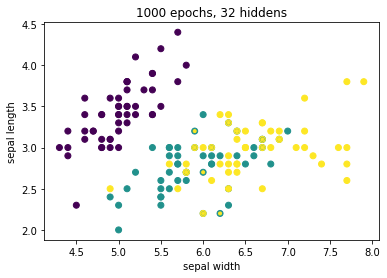

In [28]:

def plot(x, x_tensor, y, net, title):
  yh = net(x_tensor) 
  yh = torch.argmax(yh, axis=1)
  yh = yh.numpy()

  plt.scatter(x[:,0], x[:,1], c=y, marker='o', alpha=1)
  plt.scatter(x[:,0], x[:,1], c=yh, marker='.', alpha=1)

  plt.ylabel('sepal length')
  plt.xlabel('sepal width')
  plt.title(title)
  plt.show()

plot(x, x_tensor, y, net, title="1000 epochs, 32 hiddens")

### Making parameter changes

In the following experiments, we examine the effects of changing the number of hidden units in each layer and the number of epochs.

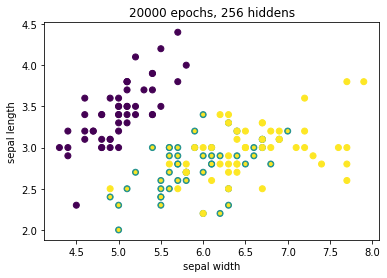

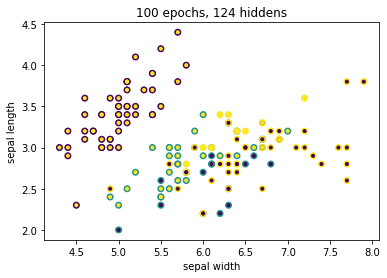

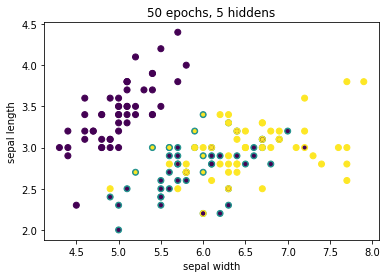

In [29]:
#Initalize your MLP
net = MLP(inputs=x_tensor.shape[1], outputs=3, hiddens = 512)

#To use GPUs, set a device (cuda) and add it to your net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

#define hyperparameters
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

#Training loop
train(30000, x_tensor, optimizer, loss_fn)


plot(x, x_tensor, y, net, title="20000 epochs, 256 hiddens")

#Initalize your MLP with 124 hiddens
net = MLP(inputs=x_tensor.shape[1], outputs=3, hiddens = 124)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

#Training loop
train(100, x_tensor, optimizer, loss_fn)

plot(x, x_tensor, y, net, title="100 epochs, 124 hiddens")

#Initalize your MLP with 5 hiddens
net = MLP(inputs=x_tensor.shape[1], outputs=3, hiddens = 5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

#Training loop
train(50, x_tensor, optimizer, loss_fn)

plot(x, x_tensor, y, net, title="50 epochs, 5 hiddens")

### Training with Train/Test Splits

As before, we can train on a training split of the data and test on a test split.

We can additionally define a torch `dataset` object and sample mini-batches from it during training.  

In the following experiments, we also examine the effect of overfitting and underfitting by tuning the number of hidden units and epochs.

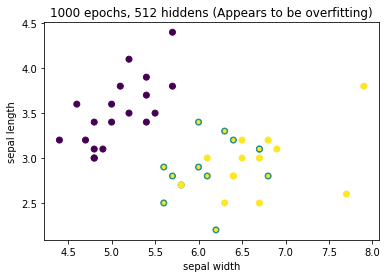

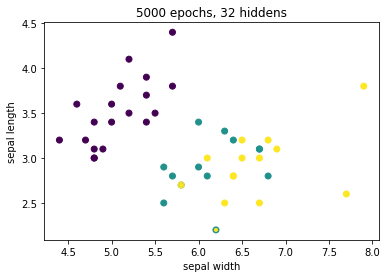

In [30]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

dataset = datasets.load_iris()

x, y = dataset['data'], dataset['target']

#We can use sk learn to break up the data into train/test splits
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

#The dataset must be converted to a tensor of the correct type
X_train = Variable(torch.from_numpy(X_train).float())
y_train   = Variable(torch.from_numpy(y_train)).long()

X_test = Variable(torch.from_numpy(X_test).float())
y_test  = Variable(torch.from_numpy(y_test)).long()

#Now we can create a training dataset which we can sample from randomly
dataset = torch.utils.data.TensorDataset( torch.Tensor(X_train), torch.Tensor(y_train) )

# We can create a data loader from the dataset
# Type of sampling and batch size are specified at this step
loader = DataLoader(dataset, batch_size=16, shuffle=True)

#Initalize your MLP
net = MLP(inputs=x_tensor.shape[1], outputs=3, hiddens = 512)

#To use GPUs, set a device (cuda) and add it to your net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

#define hyperparameters
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

for t in range(1000):

    for i, data in enumerate(loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

plot(X_test, X_test, y_test, net, title="1000 epochs, 512 hiddens (Appears to be overfitting)")

#Initalize your MLP with 32 hidden units
net = MLP(inputs=x_tensor.shape[1], outputs=3, hiddens = 32)

#To use GPUs, set a device (cuda) and add it to your net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

#define hyperparameters
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

for t in range(5000):

    for i, data in enumerate(loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

plot(X_test, X_test, y_test, net, title="5000 epochs, 32 hiddens")

### Decision Boundary Plotting

In these experiments, for simplicity we will train with only 2 features.

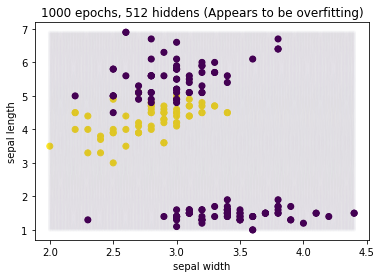

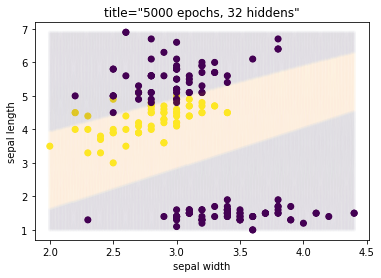

In [31]:
#Pytorch Implementation of a 2 Layer MLP
from sklearn import datasets

#We first define an nn.Module, 
class MLP(nn.Module):
  def __init__(self, inputs=2, hiddens=32):
    super(MLP, self).__init__()
    #Define the layers in your MLP
    self.fc1 = nn.Linear(inputs, hiddens)
    self.fc2 = nn.Linear(hiddens, 2)
  
  def forward(self, x):
    #Define operations on input x using the layers that were defined
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x), dim =1)
    return x

dataset = datasets.load_iris()
x, y = dataset['data'][:,[1,2]], dataset['target']
y =  y == 1

#We can use sk learn to break up the data into train/test splits
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

#The dataset must be converted to a tensor of the correct type
X_train = Variable(torch.from_numpy(X_train).float())
y_train   = Variable(torch.from_numpy(y_train)).long()

X_test = Variable(torch.from_numpy(X_test).float())
y_test  = Variable(torch.from_numpy(y_test)).long()

#Now we can create a training dataset which we can sample from randomly
dataset = torch.utils.data.TensorDataset( torch.Tensor(X_train), torch.Tensor(y_train) )

# We can create a data loader from the dataset
# Type of sampling and batch size are specified at this step
loader = DataLoader(dataset, batch_size=16, shuffle=True)

#Initalize your MLP
net = MLP(inputs=X_train.shape[1], hiddens = 512)

#To use GPUs, set a device (cuda) and add it to your net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

#define hyperparameters
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

for t in range(1000):

    for i, data in enumerate(loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

yh = net(X_test) 
yh = yh.detach().numpy()
yh = np.argmax(yh,axis=1)
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='o', alpha=1)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
x_all_ten = Variable(torch.from_numpy(x_all).float())
yh_all = net(x_all_ten)
yh_all = yh_all.detach().numpy()
yh_all = np.argmax(yh_all,axis=1)
plt.scatter(x[:,0], x[:,1], c=y, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.title("1000 epochs, 512 hiddens (Appears to be overfitting)")
plt.show()

#Initalize your MLP with 32 hidden units
net = MLP(inputs=X_train.shape[1], hiddens = 32)

#To use GPUs, set a device (cuda) and add it to your net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

#define hyperparameters
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

for t in range(5000):

    for i, data in enumerate(loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

yh = net(X_test) 
yh = yh.detach().numpy()
yh = np.argmax(yh,axis=1)
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='o', alpha=1)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
x_all_ten = Variable(torch.from_numpy(x_all).float())
yh_all = net(x_all_ten)
yh_all = yh_all.detach().numpy()
yh_all = np.argmax(yh_all,axis=1)
plt.scatter(x[:,0], x[:,1], c=y, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.title('title="5000 epochs, 32 hiddens"')
plt.show()

### Tensorflow implementation

Tensorflow is very similar to PyTorch, also allowing auto differentiation and fast matrix computations.  Objects are stored as `tf.Tensor` objects.  Keras is a wrapper over Tensorflow that allows very easy definition of neural network layers.  

We must remember to convert values to categorical one-hot encoded variables.

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from pandas import get_dummies
from keras.utils import to_categorical

dataset = datasets.load_iris()

x, y = dataset['data'], dataset['target']

x_tf = np.array(x).astype('float32')

#It is generally proper form to cast to a specific tensorflow Tensor type (tf.int32, tf.float32)
y_tf = np.array(y).astype('float32')

#Remeber to convert y values to one-hot encoded categorical, this is not automatically done in TF.
y_tf= to_categorical(y_tf)


## Model definition in Tensorflow

We can easily define a model as a `Sequential` object in keras and add `Dense` (fully connected layers) to it, each with its own activation.

In [33]:
# We can see its very easy to define a neural network using keras Sequential function

model = Sequential()
model.add(Dense(32, input_shape=(x_tf.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_tf.shape[1], activation='sigmoid'))

#We can print a summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________


## Tensorflow optimization and training loop

It is now easy to see that we can define an optimizer similarly to PyTorch.  the `compile` function allows us to define both the optimizer and loss for our model.  We can simply call `fit` given the inputs and labels for our model to run a training loop.

In [34]:
#Defining an optimizer and training loop is equally easy

sgd = SGD(learning_rate=0.1)
model.compile(optimizer=sgd, loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

#Simply use the fit function given the input data
model.fit(x_tf, y_tf, epochs=1000, batch_size=y_tf.shape[0], verbose=0)

## Plotting the IRIS dataset using tensorflow

5/5 [==============================] - 0s 2ms/step


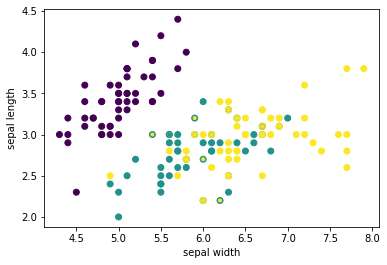

In [35]:
yh = model.predict(x_tf) 
yh = tf.argmax(yh, axis=1)
yh = yh.numpy()

plt.scatter(x[:,0], x[:,1], c=y, marker='o', alpha=1)
plt.scatter(x[:,0], x[:,1], c=yh, marker='.', alpha=1)



plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()